<div style="float: right; width: 70%; height: 150px;">
  <div style="position: relative; top: 20%;padding-right:20%;">
  <div style="font-size:280%;font-weight: bold;padding-top: 20px;"> Exercise</div>
  <div style="font-size:180%;font-weight: bold;padding-top: 20px;color: rgba(0 , 0 , 0 , 0.5);"> Numerical methods</div>
  </div>
</div>


This script will demonstrate how to use a finite-difference method to solve the wave equations.

**Questions**:<br> 
**What happens to the solution, if you decrease the grid mesh size?**<br>
**How does the time step size affect the solution?**<br> 


for more notebooks in seismology, see:<br>
https://krischer.github.io/seismo_live_build/tree/index.html


## Theory

In this example, we will solve the 1D wave equation for a homogeneous media:
$$
\partial_t^2 u(x,t) = c^2 \partial_x^2 u(x,t)
$$
where we have introduced the wave speed $c = \sqrt{\kappa/\rho}$ (with $\kappa$ being the bulk modulus, and $\rho$ density) for compressional wave propagation.


### Discretization

The finite-difference method approximates the differential operators with numerical schemes using small temporal $\Delta t$ and spatial $\Delta x$ discretizations. Here, we will approximate the differential operators $\partial_t^2$ and $\partial_x^2$ with a second-order central difference scheme:
$$
\partial_t^2 u \approx \frac{u(x,t+\Delta t) - 2 u(x,t) + u(x,t-\Delta t)}{\Delta t^2}
$$
and
$$
\partial_x^2 u \approx \frac{u(x+\Delta x,t) - 2 u(x,t) + u(x-\Delta x,t)}{\Delta x^2}
$$

Let us introduce the discretization for space $x_i = i * \Delta x$ and time $t^n = n * \Delta t$, and simplify the notation by using just the indices $n$ for the temporal time $t^n$ and $i$ for the spatial position $x_i$. Then, time $t^n + \Delta t$ becomes index $n + 1$, position $x_i + \Delta x$ becomes $i + 1$ and we can rewrite the wave equation in its discretized form:
$$
\frac{u_i^{n+1} - 2 u_i^n + u_i^{n-1}}{\Delta t^2} = c^2 \frac{u_{i+1}^n - 2 u_i^n + u_{i-1}^n}{\Delta x^2}
$$
where we want to solve the displacement $u(x,t)$ on all the grid positions $x_i = i * \Delta x$ and times $t^n = n * \Delta t$. 

### Explicit formulation of the wave equation

With our choice of using the central difference scheme for both derivatives and the subsequent discretized version of the wave equation, we find that the displacement at time $t^n + \Delta t$ can be written as
$$
u_i^{n+1} = 2 u_i^n - u_i^{n-1} + \Delta t^2 c^2 \frac{u_{i+1}^n - 2 u_i^n + u_{i-1}^n}{\Delta x^2} 
$$
That is, the displacement $u(x_i,t^{n+1})$ only depends on displacement values of the previous time steps $t^n$ and $t^{n-1}$. This is a so-called explicit scheme to solve for the updates. 


### Analytical solution

It's always a great idea to compare to an analytical solution whenever possible. That will provide us an idea about the accuracy of the numerical solution. 
For this simple wave equation and initial value problem, let's write again the wave equation as
$$
u_{tt} = c^2 u_{xx}
$$
with the initial conditions for displacement and velocity 
$$
u(x,0) = \phi(x)   \,\, \textrm{and} \,\, u_t(x,0) = \psi(x)
$$


The general solution can be written in the form $u(x,t) = f(x + c t) + g(x - c t)$
with $\phi(x) = f(x) + g(x)$ and $\psi(x) = c f'(x) + c g'(x)$. Solving for $f$ and $g$, one finds that the solution can be written as
$$
u(x,t) = \frac{1}{2} [ \phi(x + ct) + \phi(x - ct) ] + \frac{1}{2c} \int_{x-ct}^{x+ct} \psi(s) ds
$$


In our case, we can further simplify it as our initial velocity will be zero, thus $\psi(x) = 0$ and the displacement solution becomes
$$
u(x,t) = \frac{1}{2} [ \phi(x + ct) + \phi(x - ct) ]
$$


Let's calculate this now...

## 0. Setup

Note: this python script requires extra packages for
    - matplotlib (version 2.1.2) : > pip install -U matplotlib
    - numpy      (version 1.14.0): > pip install -U numpy
    - obspy      (version 1.1.0) : > pip install -U obspy

In [1]:
from __future__ import print_function
import os,sys

# for fixed plots
%matplotlib inline
# for interactive plots
#%matplotlib notebook
from IPython.display import display, clear_output

import matplotlib as mpl
print("matplotlib version: ",mpl.__version__)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 20, 5
plt.rcParams['lines.linewidth'] = 0.5

## numpy
import numpy as np
print("numpy version: ",np.__version__)

# do not show scipy warnings
import warnings
warnings.filterwarnings('ignore')

matplotlib version:  3.5.1
numpy version:  1.21.5




## 1. Model

We first specify a discretization of the model.<br>



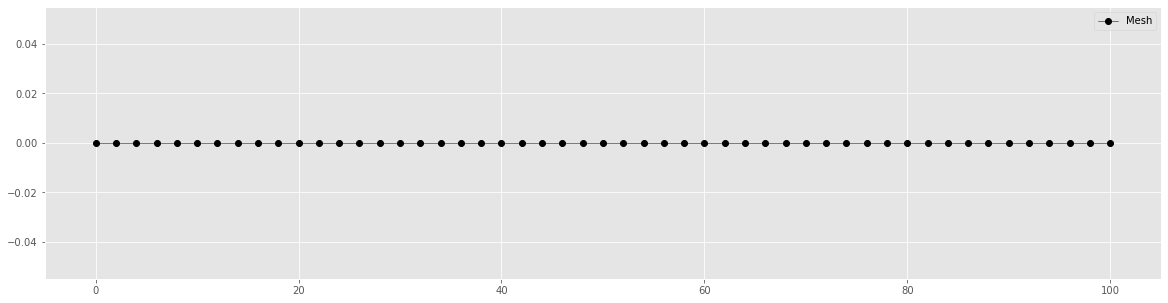

In [2]:
# meshing parameters
dx = 2.0                        # grid size
x = np.arange(0,100.0+dx/2,dx)  # coordinates of grid points: 0-100
nx = len(x)                     # number of grid points

## material properties
rho = np.ones(nx)               # density = 1 (kg/m^3)
kappa = np.ones(nx)             # bulk modulus = 1 Pa = 1 N/m^2 = 1 kg/(m s^2)

c  = np.sqrt(kappa/rho)         # wavespeed in m/s
c2 = kappa/rho                  # wavespeed square: c^2

# plot
plt.plot(x, np.zeros(nx), marker='o', color='black', label='Mesh')
plt.legend()
plt.show()

## 2. Time 

Here we choose a time step size

In [3]:
# timing parameters
FACTOR = 0.25

dt = FACTOR * np.min(dx**2/c2)      # time step
dt = np.round(dt,decimals=4)        # round-off 4 digit

T_total = 20.0                      # simulation time: 0-200
t = np.arange(0,T_total+dt/2,dt)
nt = len(t)

print("time step dt = ",dt)
print("number of time steps nt = ",nt)
print("")



time step dt =  1.0
number of time steps nt =  21



## 3. Initial conditions

Let's assign an initial displacement of the form $u(x,0) = \phi(x)$ with $\phi(x) = e^{-\sigma(x-50)}$ where $\sigma = 0.1$:

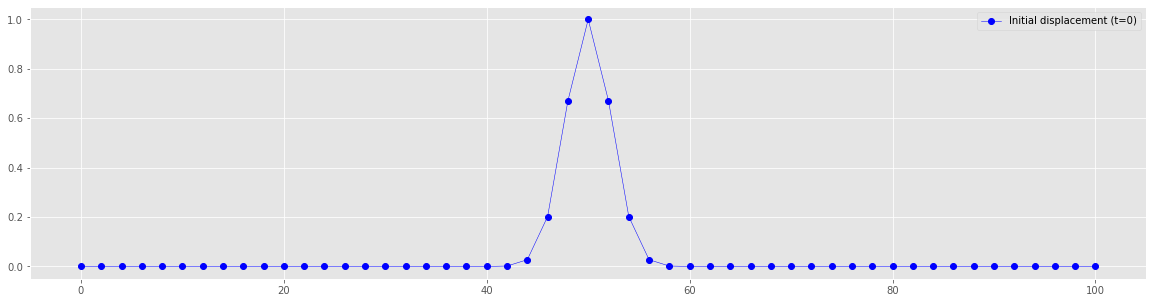

In [4]:
# wavefields
u         = np.zeros(nx)  # displacement at time t^n
u_nminus1 = np.zeros(nx)  #                 time t^{n-1}
u_nplus1  = np.zeros(nx)  #                 time t^{n+1}

u_analytic = np.zeros(nx)  # analytical solution

# initial displacement function
def phi_function(x):
    # initial displacement
    sigma = 0.1
    phi = np.exp(-sigma*(x-50)**2) 
    return phi

# initial condition
def initialize():
    global u,u_nminus1,u_nplus1    
    # initial displacement
    u = phi_function(x)
    # same for previous (zero velocity from previous time step)
    u_nminus1 = np.copy(u)
    # same for next (zero velocity for upcoming time step)
    u_nplus1 = np.copy(u)

initialize()

# plot
plt.plot(x, u, marker='o', color='b', label='Initial displacement (t=0)')
plt.legend()
plt.show()

Now we're all set and can start propagating waves in our time loop:

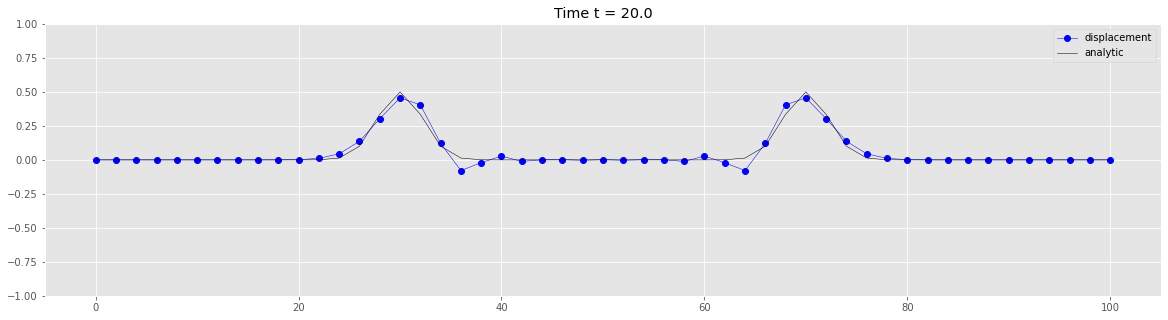

In [5]:
print("starting time loop ... ")
print("")

# initialize
initialize()

# set up plot
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 

# time marching
for it in np.arange(0,nt):

    # time scheme
    u_nminus1 = np.copy(u)
    u = np.copy(u_nplus1)

    # finite-difference update
    for i in np.arange(1,nx-1):
        u_nplus1[i] = 2*u[i]-u_nminus1[i]+(dt*dt*c2[i]/(dx*dx))*(u[i+1]-2*u[i]+u[i-1])

    # plot figure
    if (it+1)%2 == 0:
        t_nplus1 = (it+1) * dt
        
        # analytical solution
        for ix in np.arange(len(x)):
            x_pos = ix * dx # position
            f = phi_function(x_pos + c[ix] * t_nplus1)
            g = phi_function(x_pos - c[ix] * t_nplus1)            
            u_analytic[ix] = 1.0/2.0 * ( f + g)
            
        # plotting
        t_nplus1 = np.round(t_nplus1,decimals=4)        # round-off 4 digit
        print("time step ",it," - time = ",t_nplus1)

        # plots displacement  
        clear_output(wait=True)
        plt.title('Time t = ' + str(t_nplus1))
        plt.plot(x, u_nplus1, marker='o', color = 'b', label = 'displacement')
        plt.plot(x, u_analytic, color = 'black', label = 'analytic')
        plt.ylim(-1,1)
        plt.legend()
        #plt.show()
        plt.pause(0.5)
        print("")


Now, change the grid size and see what happens. Then, make the time step size factor much bigger and play again...